In [6]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
import astropy.units as u

In [3]:
with fits.open('/data2/lsajkov/mpdg/data/DESI/edr_galaxy_stellarmass_lineinfo_v1.0.fits') as edr_cat:
    edr_cat = Table(edr_cat[1].data)

In [10]:
r_mag = 22.5 - 2.5 * np.log10(edr_cat['FLUX_R'])
r_mag_invar = 22.5 - 2.5 * np.log10(edr_cat['FLUX_IVAR_R'])

g_mag = 22.5 - 2.5 * np.log10(edr_cat['FLUX_G'])
g_mag_invar = 22.5 - 2.5 * np.log10(edr_cat['FLUX_IVAR_G'])

z_mag = 22.5 - 2.5 * np.log10(edr_cat['FLUX_Z'])
z_mag_invar = 22.5 - 2.5 * np.log10(edr_cat['FLUX_IVAR_Z'])

/var/tmp/lsajkov/ipykernel_3405058/2020583550.py:1: RuntimeWarning: divide by zero encountered in log10
  r_mag = 22.5 - 2.5 * np.log10(edr_cat['FLUX_R'])
/var/tmp/lsajkov/ipykernel_3405058/2020583550.py:1: RuntimeWarning: invalid value encountered in log10
  r_mag = 22.5 - 2.5 * np.log10(edr_cat['FLUX_R'])
/var/tmp/lsajkov/ipykernel_3405058/2020583550.py:2: RuntimeWarning: divide by zero encountered in log10
  r_mag_invar = 22.5 - 2.5 * np.log10(edr_cat['FLUX_IVAR_R'])
/var/tmp/lsajkov/ipykernel_3405058/2020583550.py:2: RuntimeWarning: invalid value encountered in log10
  r_mag_invar = 22.5 - 2.5 * np.log10(edr_cat['FLUX_IVAR_R'])
/var/tmp/lsajkov/ipykernel_3405058/2020583550.py:5: RuntimeWarning: divide by zero encountered in log10
  g_mag = 22.5 - 2.5 * np.log10(edr_cat['FLUX_G'])
/var/tmp/lsajkov/ipykernel_3405058/2020583550.py:5: RuntimeWarning: invalid value encountered in log10
  g_mag = 22.5 - 2.5 * np.log10(edr_cat['FLUX_G'])
/var/tmp/lsajkov/ipykernel_3405058/2020583550.py:6:

In [17]:
edr_cat['SPECTYPE']

KeyError: 'SPECTYPE'

Text(0.5, 0, '$r$-mag')

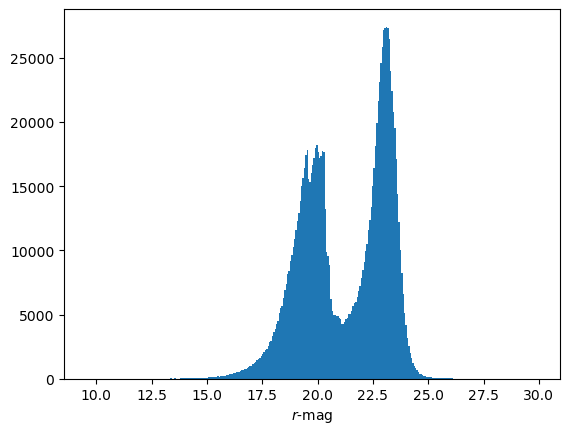

In [16]:
plt.hist(r_mag[r_mag < 30], bins = 'auto')
plt.xlabel('$r$-mag')

In [ ]:
edr_cat['FLUX_G']